**CS 541 Deep Learning**

Homework 3 Problem 4

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

In [10]:
#| label: task1

# Task 1

def prepare_data(batch_size: int = 128):
    transform = transforms.ToTensor()  # 28x28 grayscale -> float tensor in [0,1]

    train_set = torchvision.datasets.FashionMNIST(
        root="./", train=True, download=True, transform=transform
    )
    test_set = torchvision.datasets.FashionMNIST(
        root="./", train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2)

    # quick checks
    print("\nData:")
    print(f"- train samples: {len(train_set)}")
    print(f"- test samples : {len(test_set)}")
    print(f"- image shape  : {train_set[0][0].shape}")  # (1, 28, 28)
    print(f"- train batches: {len(train_loader)}")
    return train_loader, test_loader

# run task 1
train_loader, test_loader = prepare_data(batch_size=128)



Data:
- train samples: 60000
- test samples : 10000
- image shape  : torch.Size([1, 28, 28])
- train batches: 469


In [11]:
#| label: task2

# Task 2

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128), nn.ReLU(),
            nn.Linear(128, 64),  nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),  nn.ReLU(),
            nn.Linear(128, 784), nn.Sigmoid(),  # keep outputs in [0,1]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decoder(self.encoder(x))

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

# build model and show size
model = Autoencoder()
params = sum(p.numel() for p in model.parameters())
print("Model ready")
print(f"- parameters: {params:,}")


Model ready
- parameters: 218,192


In [12]:
#| label: task3

# Task 3

def train_autoencoder(model: nn.Module, loader: DataLoader, epochs: int = 20, lr: float = 1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    print(f"Training on {device} for {epochs} epochs")
    losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        running = 0.0

        for i, (imgs, _) in enumerate(loader):
            imgs = imgs.to(device).view(imgs.size(0), -1)   # (B, 1, 28, 28) -> (B, 784)

            opt.zero_grad()
            out = model(imgs)
            loss = loss_fn(out, imgs)
            loss.backward()
            opt.step()

            running += loss.item()
            if i % 100 == 0:
                print(f"  epoch {epoch:2d} | batch {i:4d}/{len(loader)} | loss {loss.item():.4f}")

        avg = running / len(loader)
        losses.append(avg)
        print(f"  epoch {epoch:2d} complete | avg loss {avg:.4f}")

    return model, losses

# run task 3
model, losses = train_autoencoder(model, train_loader, epochs=20, lr=1e-3)


Training on cuda for 20 epochs
  epoch  1 | batch    0/469 | loss 0.1683
  epoch  1 | batch  100/469 | loss 0.0449
  epoch  1 | batch  200/469 | loss 0.0267
  epoch  1 | batch  300/469 | loss 0.0231
  epoch  1 | batch  400/469 | loss 0.0232
  epoch  1 complete | avg loss 0.0375
  epoch  2 | batch    0/469 | loss 0.0220
  epoch  2 | batch  100/469 | loss 0.0206
  epoch  2 | batch  200/469 | loss 0.0188
  epoch  2 | batch  300/469 | loss 0.0195
  epoch  2 | batch  400/469 | loss 0.0180
  epoch  2 complete | avg loss 0.0196
  epoch  3 | batch    0/469 | loss 0.0184
  epoch  3 | batch  100/469 | loss 0.0178
  epoch  3 | batch  200/469 | loss 0.0167
  epoch  3 | batch  300/469 | loss 0.0169
  epoch  3 | batch  400/469 | loss 0.0160
  epoch  3 complete | avg loss 0.0169
  epoch  4 | batch    0/469 | loss 0.0156
  epoch  4 | batch  100/469 | loss 0.0157
  epoch  4 | batch  200/469 | loss 0.0143
  epoch  4 | batch  300/469 | loss 0.0141
  epoch  4 | batch  400/469 | loss 0.0146
  epoch  4 comp

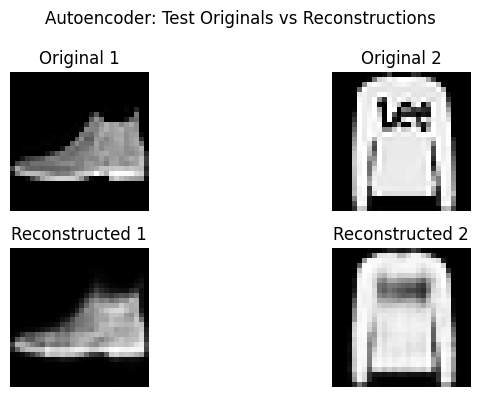

In [13]:
#| label: task4
#| fig-cap: "Autoencoder reconstructions on test set: Originals (top) vs Reconstructions (bottom)."
#| fig-pos: 'H'

# Task 4

def visualize_reconstructions(model: nn.Module, test_loader: DataLoader, num_images: int = 2):
    model.eval()
    device = next(model.parameters()).device

    images, _ = next(iter(test_loader))           # one batch is enough
    images = images.to(device)
    with torch.no_grad():
        recon = model(images.view(images.size(0), -1)).view(-1, 1, 28, 28)

    images = images.cpu()
    recon = recon.cpu()

    fig, axes = plt.subplots(2, num_images, figsize=(8, 4))
    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze(), cmap="gray"); axes[0, i].set_title(f"Original {i+1}"); axes[0, i].axis("off")
        axes[1, i].imshow(recon[i].squeeze(),   cmap="gray"); axes[1, i].set_title(f"Reconstructed {i+1}"); axes[1, i].axis("off")
    fig.suptitle("Autoencoder: Test Originals vs Reconstructions")
    plt.tight_layout()
    plt.show()

# run task 4
visualize_reconstructions(model, test_loader, num_images=2)
